<a href="https://colab.research.google.com/github/ssaran2014/tensorflow/blob/master/shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to generate a somewhat relevant stream of words, given a context, using a recurrent neural network. The context here is the full works of Shakespeare. 

There are several approaches. The two most common ones are to predict character by character or to predict word by word. This notebook does the latter. The former approach can be seen here: https://www.tensorflow.org/tutorials/text/text_generation

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [15]:
#download the complete works os Shakespeare
#http://www.gutenberg.org/files/100/100-0.txt

def load_data():
  url = 'http://www.gutenberg.org/files/100/100-0.txt'

  path_to_file = tf.keras.utils.get_file('shakespeare.txt', url)

  r = open(path_to_file, 'rb').read().decode(encoding='utf-8').replace('\r', '').lower().split('\n')

  return r

cleaned_data = load_data()

In [16]:
def create_subset(master_list, subset = 20000):
  return master_list[:subset]
subset_list = create_subset(cleaned_data)
#len(subset_list)

In [17]:
def create_word_index(cleaned_data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(cleaned_data)
  total_words = len(tokenizer.word_index) + 1
  print('Total number of words: {}'.format(total_words))
  return tokenizer, total_words

tokenizer, total_words = create_word_index(subset_list)

Total number of words: 9589


In [18]:
def preprocess(cleaned_data, total_words, tokenizer):

  #converting each line to a sequence of numbers based on the word index
  input_sequences = []
  for line in cleaned_data:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #removing blank lines
    if len(token_list)>0: 
      for i in range(1, len(token_list)):
        input_sequences.append(token_list[:i+1])

  #padding the sequences 
  max_sequence_len = max([len(x) for x in input_sequences])
  input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

  # create predictors and label
  xs, labels = input_sequences[:,:-1], input_sequences[:,-1]

  #convert labels to categorical (numpy array)
  ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

  return xs, ys, max_sequence_len

xs, ys, max_sequence_len = preprocess(subset_list, total_words, tokenizer)

In [19]:
#define model
def define_model(total_words, max_sequence_len):
  embedding_dim = 32
  input_length = max_sequence_len - 1

  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(total_words, embedding_dim, input_length = input_length),
                               tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
                               tf.keras.layers.Dense(total_words, activation = 'softmax')
  ])

  model.summary()

  model.compile(
      optimizer = 'adam',
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )

  return model

model = define_model(total_words, max_sequence_len)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 32)            306848    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               219600    
_________________________________________________________________
dense_1 (Dense)              (None, 9589)              2886289   
Total params: 3,412,737
Trainable params: 3,412,737
Non-trainable params: 0
_________________________________________________________________


In [20]:
def history(model, xs, ys):
  history = model.fit(xs, ys,
                      epochs = 150,
                      verbose = 1)
  return history

history = history(model, xs, ys)

Epoch 1/150
2825/2825 [==============================] - 30s 11ms/step - loss: 6.8007 - accuracy: 0.0425
Epoch 2/150
2825/2825 [==============================] - 29s 10ms/step - loss: 6.2282 - accuracy: 0.0767
Epoch 3/150
2825/2825 [==============================] - 29s 10ms/step - loss: 5.8713 - accuracy: 0.0959
Epoch 4/150
2825/2825 [==============================] - 29s 10ms/step - loss: 5.5538 - accuracy: 0.1073
Epoch 5/150
2825/2825 [==============================] - 29s 10ms/step - loss: 5.2459 - accuracy: 0.1188
Epoch 6/150
2825/2825 [==============================] - 29s 10ms/step - loss: 4.9418 - accuracy: 0.1309
Epoch 7/150
2825/2825 [==============================] - 29s 10ms/step - loss: 4.6373 - accuracy: 0.1520
Epoch 8/150
2825/2825 [==============================] - 29s 10ms/step - loss: 4.3415 - accuracy: 0.1806
Epoch 9/150
2825/2825 [==============================] - 29s 10ms/step - loss: 4.0625 - accuracy: 0.2122
Epoch 10/150
2825/2825 [==============================]

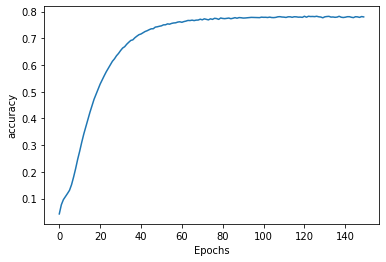

In [21]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [23]:
def create_play(tokenizer, model):
  seed_text = "if you survive this"
  next_words = 100

  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list)) #model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word
  print(seed_text)

create_play(tokenizer, model)

if you survive this more but i have no health with you with my house if i do not eros my lord but when i should not tell thee revenges as well of my worth of weeping ere i mangled do any most like of thee i will give a lordship by my life he says i when antonio the way of the gods blow self not hills not have hill to desired upon our own honour when he palace my lord the phoenix come no quality me in a villain i would make a will show me to he will when he at


A sequence of words is generated, but the sequence has no meaning.

In [ ]:
def be_shakespeare():
  #load full works of Shakespeare
  cleaned_data = load_data()

  #work with a subset of the data to manage memory usage
  subset_list = create_subset(cleaned_data)

  #tokenize and create word index
  tokenizer, total_words = create_word_index(subset_list)
  
  #preprocess. Convert to sequences; pad sequences and convert ys to numpy array
  xs, ys, max_sequence_len = preprocess(subset_list, total_words, tokenizer)

  #define model
  model = define_model(total_words, max_sequence_len)

  #execute model and create history
  history = history(model, xs, ys)

  #plot graphs
  plot_graphs(history, 'accuracy')

  #make some words
  create_play(tokenizer, model)

be_shakespeare()